# 核支持向量机
核支持向量机（通常简称为SVM）是可以推广到更复杂模型的扩展，这些模型无法被输入空间的超平面定义。向量机可以同时用于分类和回归。

In [1]:
import sys
print("Python version:{}".format(sys.version))

import pandas as pd
print("pandas version:{}".format(pd.__version__))

import matplotlib
print("matplotlib version:{}".format(matplotlib.__version__))
import matplotlib.pyplot as plt

import numpy as np
print("Numpy version:{}".format(np.__version__))

import scipy as sp
print("Scipy version:{}".format(sp.__version__))

import IPython
print("IPython version:{}".format(IPython.__version__))

import sklearn
print("scikit-learn version:{}".format(sklearn.__version__))

import mglearn
import graphviz

Python version:3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas version:0.23.4
matplotlib version:3.0.2
Numpy version:1.15.4
Scipy version:1.1.0
IPython version:7.2.0
scikit-learn version:0.20.1


# 线性模型与非线性验证
线性模型在低维空间中可能非常受限，因为线和平面的灵活性有限。有一种方法可以让线性模型更加灵活，就是添加更多的特征——举个例子，添加输入特征的交互项或多项式。

Text(0, 0.5, 'Feaature 1')

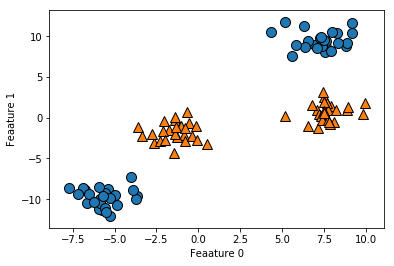

In [2]:
from sklearn.datasets import make_blobs
X,y=make_blobs(centers=4,random_state=8)

y=y%2

mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feaature 0")
plt.ylabel("Feaature 1")

用于分类的线性模型只能用一条直线来划分数据点，对这个数据集无法给出较好的结果：

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Feaature 1')

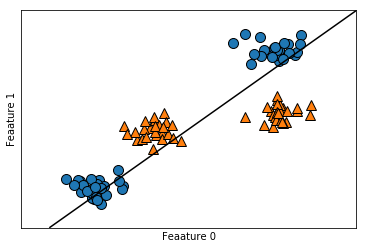

In [3]:
from sklearn.svm import LinearSVC

linear_svm=LinearSVC().fit(X,y)

mglearn.plots.plot_2d_separator(linear_svm,X)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feaature 0")
plt.ylabel("Feaature 1")

现在我们对输入特征进行扩展，比如说添加第二个特征的平方（feature1 ** 2）作为一个新特征，现在我们将每个数据点表示为三维点（feature0,feature1,feature1 ** 2）,而不是二维点（feature0,feature1）。我们将这个心的表示画出三维散点图：

Text(0.5, 0, 'feature1**2')

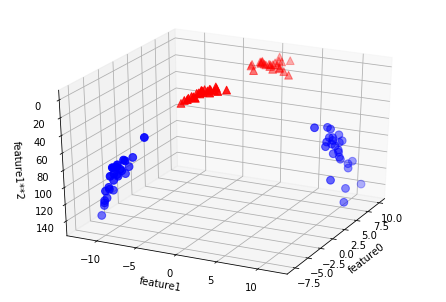

In [4]:
X_new=np.hstack([X,X[:,1:]**2])

from mpl_toolkits.mplot3d import Axes3D,axes3d
figure=plt.figure()
# 3D可视化
ax=Axes3D(figure,elev=-152,azim=-26)
# 首先画出所有y==0的点，然后画出所有y==1的点
mask= y==0
ax.scatter(X_new[mask,0],X_new[mask,1],X_new[mask,2],c='b',cmap=mglearn.cm2,s=60)
ax.scatter(X_new[~mask,0],X_new[~mask,1],X_new[~mask,2],c='r',marker='^',cmap=mglearn.cm2,s=60)
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1**2")

在数据的新表示中，现在可以用线性模型（三维空间中的平面）将这两个类别分开。我们可以用线性模型拟合扩展后的数据来验证这一点：

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0.5, 0, 'feature1**2')

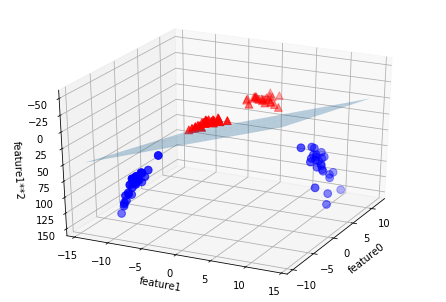

In [5]:
linear_svm_3d=LinearSVC().fit(X_new,y)
coef,intercept=linear_svm_3d.coef_.ravel(),linear_svm_3d.intercept_

# 显示线性决策边界
figure=plt.figure()
ax=Axes3D(figure,elev=-152,azim=-26)
xx=np.linspace(X_new[:,0].min()-2,X_new[:,0].max()+2,50)
yy=np.linspace(X_new[:,1].min()-2,X_new[:,1].max()+2,50)

XX,YY=np.meshgrid(xx,yy)
ZZ=(coef[0]*XX+coef[1]*YY+intercept)/-coef[2]
ax.plot_surface(XX,YY,ZZ,rstride=8,cstride=8,alpha=0.3)
ax.scatter(X_new[mask,0],X_new[mask,1],X_new[mask,2],c='b',cmap=mglearn.cm2,s=60)
ax.scatter(X_new[~mask,0],X_new[~mask,1],X_new[~mask,2],c='r',marker='^',cmap=mglearn.cm2,s=60)

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1**2")

如果将线性模型SVM看作原始特征的函数，那么它实际上已经不是线性的了。它不是一条直线，而是一个椭圆，你可以在下图中看出:

Text(0, 0.5, 'Feature 1')

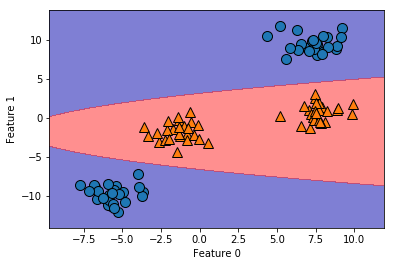

In [6]:
ZZ=YY**2
dec=linear_svm_3d.decision_function(np.c_[XX.ravel(),YY.ravel(),ZZ.ravel()])
plt.contourf(XX,YY,dec.reshape(XX.shape),levels=[dec.min(),0,dec.max()],cmap=mglearn.cm2,alpha=0.5)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

# 核技巧
向数据表示中添加非线性特征，可以让线性模型变得更强大。但是，通常来说我们并不知道要添加哪些特征，而且添加许多特征（比如100维特征空间所有可能的交互项）的计算开销可能很大。幸运的是，有一种巧妙的数学技巧，让我们可以在更高维空间中学习分类器，而不用实际计算可能非常大的新的数据表示。这种技巧叫作核技巧（kernel trick）,它的原理是直接计算扩展特征表示表示中数据点之间的距离（更准确地说是内积），而不用对扩展进行计算。 
对于支持向量机，将数据映射到更高维空间中有两种常用的方法：一种是多项式核，在一定阶数内计算原始特征所有可能的多项式（比如feature1 ** 2 ** feature2 ** 5）;另一种是径向基函数（radial basis function,RBF）核，也叫高斯核。高斯核有点难以解释，因为它对应无限维的特征空间。一种对高斯核的解释是它考虑所有阶数的所有可能的多项式，但阶数越高，特征的重要性越小。  

# 理解SVM
在训练过程中，SVM学习每个训练数据点对于表示两个类别之间的决策边界的重要性。通常只有一部分训练数据点对于定义边界来说很重要：位于类别之间边界上的那些点。这些点叫作**支持向量（support vector）**,支持向量机正是由此得名。  
想要对新样本进行预测，需要测量它与每个支持向量机之间的距离。分类决策是基于它与支持向量之间的距离以及在训练过程中学到的支持向量重要性（保存在SVC的dual_coef_属性中）来做出的。  
数据点之间的距离有高斯核给出：
Krbf(x1,x2)=exp(-Y||x1-x2|| ** 2)  
这里x1和x2是数据点，||x1-x2||表示欧式距离，y(gamma)是控制高斯核宽度的参数。  
如下是支持向量机对于一个二维二分类数据集的训练结果。决策边界用黑色表示，支持向量是尺寸较大的点：

Text(0, 0.5, 'Feature 1')

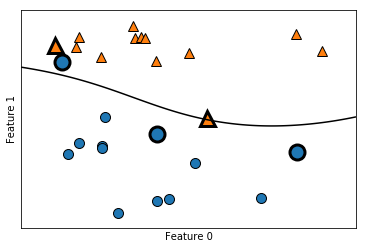

In [11]:
from sklearn.svm import SVC

X,y=mglearn.tools.make_handcrafted_dataset()
svm=SVC(kernel='rbf',C=10,gamma=0.1).fit(X,y)
mglearn.plots.plot_2d_separator(svm,X,eps=.5)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
# 画出支持向量
sv=svm.support_vectors_
# 支持向量的类别标签由dual_coef_的正负号给出
sv_labels=svm.dual_coef_.ravel()>0
mglearn.discrete_scatter(sv[:,0],sv[:,1],sv_labels,s=15,markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

在这个例子中，SVM给出了非常平滑且非线性（不是直线）的边界。这里我们调节了两个参数：C参数和gamma参数，下面详细讨论这两个参数：

# SVM调参
gamma参数是上一节给出的公式总的参数，用于控制高斯核的宽度。它决定了点与点之间“靠近”是指多大的距离。C参数是正则化参数，它限制每个点的重要性（或者确切地说，每个点的dual_coef_）。

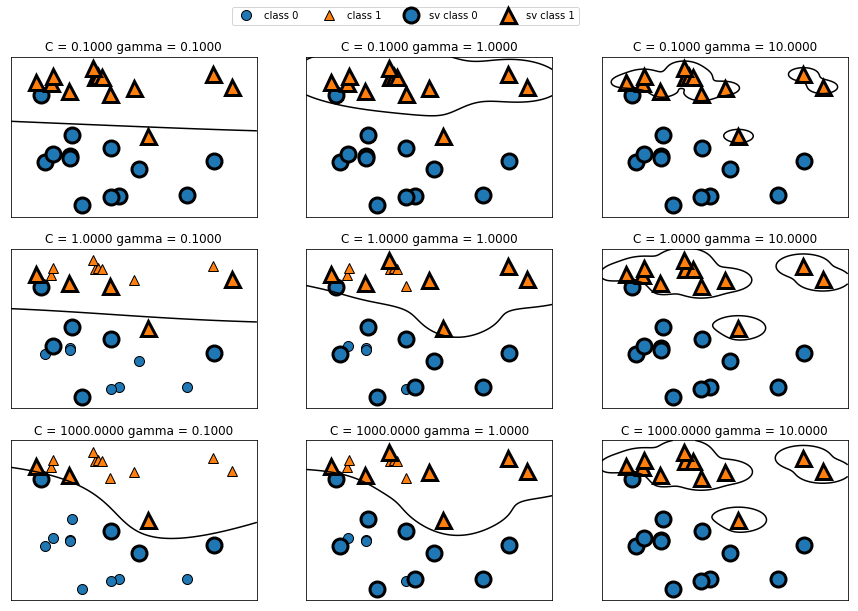

In [16]:
fig,axes=plt.subplots(3,3,figsize=(15,10))
for ax,C in zip(axes,[-1,0,3]):    
    for a,gamma in zip(ax,range(-1,2)):
        mglearn.plots.plot_svm(log_C=C,log_gamma=gamma,ax=a)
axes[0,0].legend(["class 0","class 1","sv class 0","sv class 1"],ncol=4,loc=(.9,1.2))

从左到右，我们将参数gamma的值从0.1增加到10。gamma较小，说明高斯核的半径较大，许多点都被看作比较靠近。这一点可以在图中看出：左侧的图决策边界非常平滑，越向右的图决策边界更关注单个点。小的gamma值表示决策边界变化很慢，生成的是复杂度较低的模型，而大的gamma值则会生成更为复杂的模型。  
从上到下，我们将参数C的值从0.1增加到1000。与线性模型相同，C值很小，说明模型非常受限，每个数据点的影响范围有限。你可以看到，左上角的图中，决策边界看起来几乎是线性的，误分类的点对边界几乎没有任何影响。再看左下的图，增大C之后这些点对模型的影响变大，使得决策边界发生弯曲来将这些点正确分类。  
我们将RBF核SVM应用到乳腺癌数据集上。默认情况下，C=1,gamma=1/n_features:

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer=load_breast_cancer()
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)
svc=SVC()
svc.fit(X_train,y_train)

print("Accuracy on training set:{:.2f}".format(svc.score(X_train,y_train)))
print("Accuracy on test set:{:.2f}".format(svc.score(X_test,y_test)))

Accuracy on training set:1.00
Accuracy on test set:0.63


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


这个模型在训练集上的分数十分完美，但在测试集上的精度只有63%，存在相当严重的过拟合。虽然SVM的表现通常都很好，但它对参数的设定和数据的缩放非常敏感。特别地，它要求所有特征都有相似的变化范围。我们来看一下每个特征的最小值和最大值，它们绘制在对数坐标上：

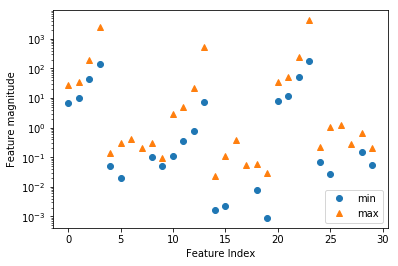

In [18]:
plt.plot(X_train.min(axis=0),'o',label='min')
plt.plot(X_train.max(axis=0),'^',label='max')
plt.legend(loc=4)
plt.xlabel("Feature Index")
plt.ylabel("Feature magnitude")
plt.yscale("log")

从上述图中，我们可以确定乳腺癌数据集的特征具有完全不同的数量级。这对其他模型来说（比如线性模型）可能是小问题，但对SVM却有极大影响。我们来研究处理这个问题的几种方法：

 ## 为SVM处理数据
 解决这个问题的一种方法是对每个特征进行缩放，使其大致都位于同一范围。核SVM常用的缩放方法就是将所有特征缩放到0和1之间：


In [24]:
# 计算训练集中每个特征的最小值
min_on_training=X_train.min(axis=0)
# 计算训练集中每个特征的范围（最大值-最小值）
range_on_training=(X_train-min_on_training).max(axis=0)
# 减去最小值，然后除以范围
# 这样每个特征都是min=0和max=1
X_train_scaled=(X_train-min_on_training)/range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n{}".format(X_train_scaled.max(axis=0)))

# 利用训练集的最小值和范围对测试集做相同的变换
X_test_scaled=(X_test-min_on_training)/range_on_training
svc=SVC()
svc.fit(X_train_scaled,y_train)

print("Accuracy on training set:{:.3f}".format(svc.score(X_train_scaled,y_train)))
print("Accuracy on test set:{:.3f}".format(svc.score(X_test_scaled,y_test)))

Minimum for each feature
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
Accuracy on training set:0.948
Accuracy on test set:0.951


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


数据缩放的作用很大!实际上模型现在处于欠拟合的状态，因为训练集和测试集的性能非常接近，但还没有接近100%的精度。从这里开始，我们可以尝试增大C或gamma来拟合更为复杂的模型。例如：

In [26]:
svc=SVC(C=1000)
svc.fit(X_train_scaled,y_train)

print("Accuracy on training set:{:.3f}".format(svc.score(X_train_scaled,y_train)))
print("Accuracy on test set:{:.3f}".format(svc.score(X_test_scaled,y_test)))

Accuracy on training set:0.988
Accuracy on test set:0.972


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# 优点、缺点和参数
核支持向量机是非常强大的模型，在各种数据集上的表现都很好。SVM允许决策边界很复杂，即使数据只有几个特征。它在低维数据和高维数据（即很少特征和很多特征）上的表现都很好，但对样本个数的缩放表现不好。在有多达10000个样本的数据上运行SVM可能表现良好，但如果数据量达到100000甚至更大，在运行时间和内存使用方面可能会面临挑战。  
SVM的另一个缺点是，预处理数据和调参都需要非常小心。这也是为什么如今很多应用用的都是基于树的模型，比如随机森林或梯度提升（需要很少的预处理，甚至不需要预处理）。此外，SVM模型很难检查，可能很难理解为什么会这么预测，而且也难以将模型向非专家进行解释。  
不过SVM仍然值得尝试的，特别是所有特征的测量单位相似（比如都是像素密度）而且范围也差不多时。  
 核SVM的主要参数是正则化参数C、核的选择与核相关的参数。RBF核只有一个参数gamma,它是高斯核宽度的倒数。gamma和C控制的都是模型复杂度，较大的值都对应更为复杂的模型。因此，这两个参数的设定通常是强烈相关的，应该同时调节。